## 1. Basic Setting 

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
if iskaggle:
  !pip install -Uqq fastai duckduckgo_search

In [3]:
!pip install duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 6.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


## 1. Download images of birds and non-birds

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url

def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results=max_images)).itemgot('image')


In [5]:
# search_images: duckduckgo.com에 의존함 (항상 올바른 response를 하지는 않음)
urls = search_images('bird photos', max_images=1)
urls[0] # show the url 

Searching for 'bird photos'


'http://hdqwalls.com/wallpapers/colorful-parrot-bird.jpg'

In [6]:
# Download and check the URL 
dest='bird.jpg'
download_url(urls[0], dest, show_progress=False)

Path('bird.jpg')

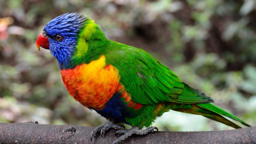

In [8]:
from fastai.vision.all import *
im = Image.open(dest) #open the image 
im.to_thumb(256,256)  #set the size of image

Searching for 'forest photos'


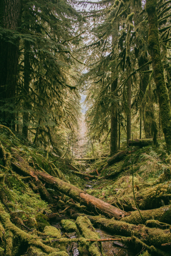

In [9]:
# 새 이미지와 비교하기 위해서 예시로 숲 사진을 다운받고 이미지를 확인한다. 
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [10]:
# 비교군에 대한 사진을 확인했으니 이제 사진을 두개의 비교군으로 나눠서 저장함 
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## 2. Train our model 

In [11]:
# If the photos are not download correctly, remove them
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

FastAI 에서는 DataBlock을 사용해서 DataBlock을 사용해서 쉽게 dataloader를 생성하고 sample image를 확인할 수 있음

DataBlock의 파라미터

* blocks = (input, output)
* get_items = get_image_files -> returns a list of all image files in a path
* splitter = RandomSplitter(valid_pct=0.2, seed=42) -> splits the data into training and validation dataset 
* get_y = parent_label -> label means the name of the parent of each file
* item_tfms= [ Resize(192, method='squish')] -> resize the image before training 

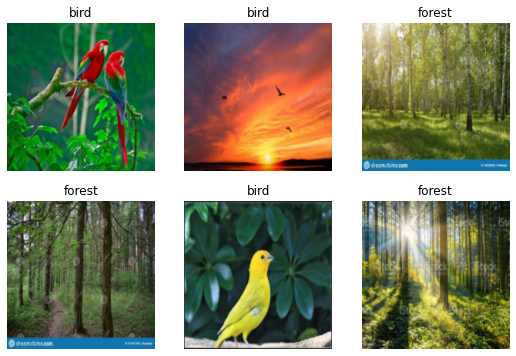

In [12]:
# 모델을 학습시키려면 DataLoader가 필요함
# 두가지 데이터를 포함: training, validation dataset
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

model: **reesnet18**    (**CVmodel**로 유명함) 
train: CPU, GPU (둘 다 가능) 

Fastai는 fine_tune( )이라는 메소드로 쉽게 fine tuning 할 수 있도록 도와줌.


In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.911962,0.565227,0.235294,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.224049,0.048370,0.029412,00:27
1,0.116712,0.008099,0.000000,00:27
2,0.078341,0.010251,0.000000,00:27


위와 같이 실행하면 validation 에서 100%의 accuracy를 볼 수 있다. (매번 다를 수 있음) 

Fine-tuning: 다른 사람이 다른 dataset으로 이미 훈련시켜 놓은 pretrained model을 이용해서 특정 dataset에 맞게 학습하도록 parameter를 조정하는 모든 과정을 의미한다. 

아래 모델의 경우 pre-trained model이 imagenet(이미지가 1000개 범주를 포함하는 범용적으로 사용되는 컴퓨터 비전 데이터 셋) 에서 사진을 인식하도록 이미 학습이 완료했다.

## 3. Use model and build it

In [14]:
# 새 이미지를 넣었을 때 새라고 나온다. 
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9998
